In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Задание

Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

# Описание данных

- `date` - дата совершения события
- `event` - событие <br>
    app_install – установка приложения<br>
    app_start – открыть приложения<br>
    registration – зарегистрироваться <br>
    search – перейти на страницу поиска товаров (каталог)<br>
    open_item – открыть товар<br>
    choose_item – отправить товар в корзину<br>
    tap_basket – перейти в корзину<br>
    purchase – подтверждение покупки<br>
- `gender` - пол пользователя
- `os_name` - платформа пользователя
- `city` - город пользователя
- `device_id` - идентификатор устройства пользователя
- `urm_source` - канал, с которого пришел пользователь <br>
    yandex-direct – Яндекс директ<br>
    google_ads – реклама в Google<br>
    vk_ads – реклама в ВК<br>
    instagram_ads – реклама в instagram<br>
    facebook_ads – реклама в facebook<br>
    referral – акция «приведи друга»<br>
    Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы<br>
- `purchase_sum` - сумма покупки при совершении события purchase

# 1. Подготовка данных, EDA

In [516]:
df = pd.read_csv('KC_case_data .csv', parse_dates = ['date'])

In [518]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [520]:
df.shape

(2747968, 8)

In [522]:
df.isna().sum()

date                  0
event                 0
purchase_sum    2606585
os_name               0
device_id             0
gender                0
city                  0
utm_source            0
dtype: int64

In [524]:
df.purchase_sum.describe()

count    141383.000000
mean        709.116092
std        1289.458186
min          61.000000
25%         226.500000
50%         394.000000
75%         560.500000
max        7884.000000
Name: purchase_sum, dtype: float64

# 2. Анализ каналов привлечения

### Количество установок по каналам

In [526]:
df_channels = df[df.utm_source != '-']

In [528]:
df_channels.shape

(2137510, 8)

In [583]:
installs = df_channels.query('event == "app_install"').drop_duplicates(subset='device_id')
installs.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
2515061,2020-01-01,app_install,NaN,ios,4921563,male,Moscow,vk_ads
2515065,2020-01-01,app_install,NaN,ios,8798567,male,Saint-Petersburg,referal
2515066,2020-01-01,app_install,NaN,android,8423608,female,Saint-Petersburg,referal
2515067,2020-01-01,app_install,NaN,android,532710,male,Moscow,yandex-direct
2515068,2020-01-01,app_install,NaN,ios,16060092,female,Moscow,vk_ads


In [532]:
installs['month'] = installs.date.dt.month

C:\Users\фвьшт\AppData\Local\Temp\ipykernel_15784\4244859674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  installs['month'] = installs.date.dt.month


In [534]:
dynamic_installs = installs.groupby(['month','utm_source'], as_index = False).device_id.count()
dynamic_installs.head()

,month,utm_source,device_id
0,1,facebook_ads,7264
1,1,google_ads,13710
2,1,instagram_ads,10409
3,1,referal,4817
4,1,vk_ads,12175


* С какого канала пришло больше всего пользователей?

In [536]:
dynamic_installs.groupby('utm_source').device_id.sum().sort_values(ascending = False)

utm_source
yandex-direct    29368
google_ads       26286
vk_ads           23189
instagram_ads    20096
facebook_ads     13916
referal           9282
Name: device_id, dtype: int64

* В каком месяце больше всего установок?

In [538]:
dynamic_installs.groupby('month').device_id.sum()

month
1    63430
2    30153
3    28554
Name: device_id, dtype: int64

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'installs'}, xlabel='month', ylabel='device_id'>

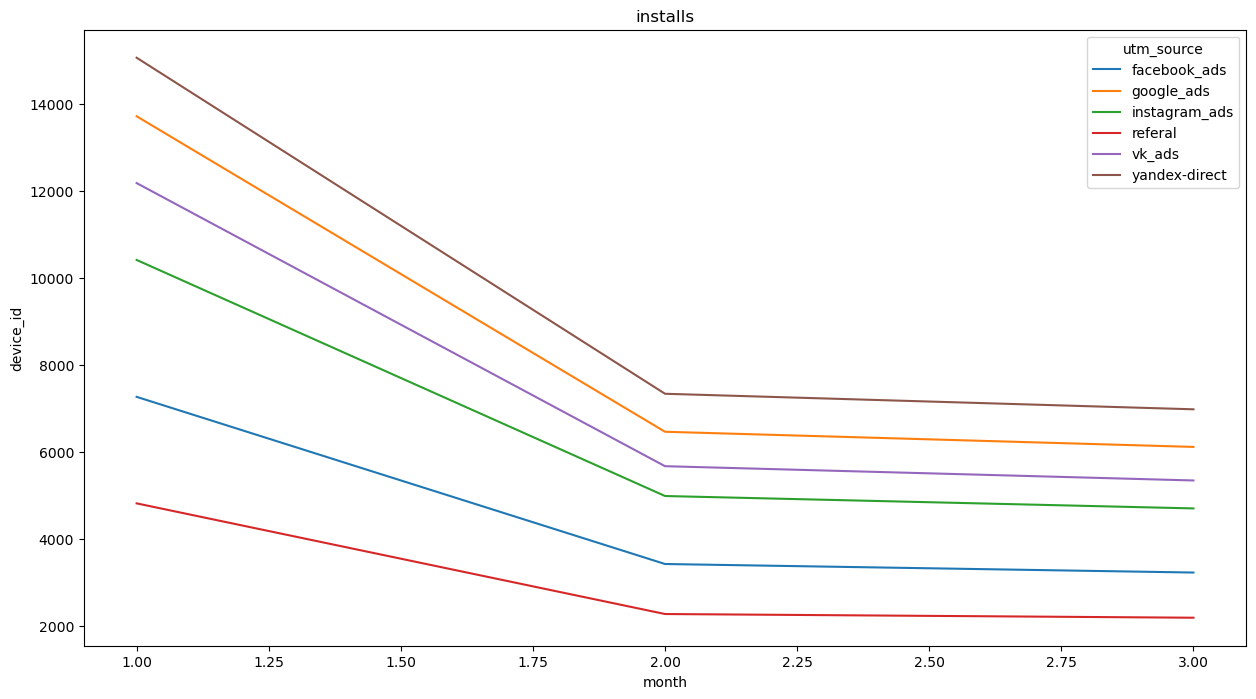

In [540]:
ax, fig = plt.subplots(figsize=(15,8))
fig.set_title('installs')
sns.lineplot(dynamic_installs, x = 'month', y = 'device_id', hue = 'utm_source')

### Конверсия в первую покупку по каналам

CR = кол-во юзеров, впервые совершивших покупку / кол-во юзеров впервые открывших приложение

In [780]:
first_purchases = df_channels.query('event == "purchase"').drop_duplicates(subset = 'device_id')
first_purchases = first_purchases[['date','device_id','utm_source', 'purchase_sum']].rename(columns = {'date' : 'purchase_date'})
first_purchases

,purchase_date,device_id,utm_source,purchase_sum
7692,2020-01-01,77448,yandex-direct,374.0
7693,2020-01-01,7458607,instagram_ads,98.5
7694,2020-01-01,3520947,instagram_ads,304.5
7695,2020-01-01,1170605,google_ads,153.5
7697,2020-01-01,27612889,google_ads,580.5
...,...,...,...,...
2507462,2020-03-31,17964402,instagram_ads,3595.0
2507463,2020-03-31,8700073,vk_ads,2861.0
2507467,2020-03-31,13278240,instagram_ads,6948.0
2507469,2020-03-31,11864116,google_ads,6546.5


In [751]:
first_start = df_channels.query('event == "app_start"').drop_duplicates(subset = 'device_id')
first_start = first_start[['utm_source','device_id']]
first_start

,utm_source,device_id
1,vk_ads,833621
2,referal,1579237
3,facebook_ads,1737182
4,facebook_ads,4029024
6,vk_ads,8383386
...,...,...
2502760,instagram_ads,3925522
2502764,google_ads,6369878
2502766,referal,9883386
2502771,instagram_ads,18983670


In [765]:
channels_purchases = first_purchases.groupby(['utm_source'], as_index = False).device_id.count().rename(columns = {'device_id' : 'count_purchases'})
channels_purchases

,utm_source,count_purchases
0,facebook_ads,8140
1,google_ads,10483
2,instagram_ads,10036
3,referal,5937
4,vk_ads,11682
5,yandex-direct,11225


In [767]:
channels_starts = first_start.groupby(['utm_source'], as_index = False).device_id.count().rename(columns = {'device_id' : 'count_starts'})
channels_starts

,utm_source,count_starts
0,facebook_ads,20429
1,google_ads,33110
2,instagram_ads,26370
3,referal,12908
4,vk_ads,29378
5,yandex-direct,36088


Самая низкая конверсия в покупку у канала **yandex-direct**

In [775]:
channels_cr = pd.merge(channels_starts, channels_purchases, on = 'utm_source')
channels_cr['cr_purchase'] = channels_cr.count_purchases / channels_cr.count_starts
channels_cr = channels_cr.sort_values('cr_purchase', ascending = False)
channels_cr

,utm_source,count_starts,count_purchases,cr_purchase
3,referal,12908,5937,0.459947
0,facebook_ads,20429,8140,0.398453
4,vk_ads,29378,11682,0.397644
2,instagram_ads,26370,10036,0.380584
1,google_ads,33110,10483,0.316611
5,yandex-direct,36088,11225,0.311045


### Медианный первый чек по каналам

In [786]:
first_purchases.groupby('utm_source').purchase_sum.median().sort_values(ascending = False)

utm_source
referal          395.50
instagram_ads    393.50
yandex-direct    393.00
vk_ads           392.50
google_ads       389.50
facebook_ads     389.25
Name: purchase_sum, dtype: float64

### ROMI по каналам

`ROMI (return on marketing investments)` - отдача на маркетинговые инвестиции

**Маркетинговые расходы по каналам**

Yandex = 10 491 707 руб. <br>
Google = 10 534 878 руб. <br>
Facebook = 8 590 498 руб. <br>
Instagramm = 8 561 626 руб. <br>
VK = 9 553 531 руб. <br>

In [796]:
yandex_cost = 10_491_707
google_cost = 10_534_878
facebook_cost = 8_590_498
insta_cost = 8_561_626
vk_cost = 9_553_531

In [802]:
channels_revenue = df.groupby('utm_source').purchase_sum.sum()
channels_revenue

utm_source
-                21449749.5
facebook_ads     12249901.0
google_ads       12868276.0
instagram_ads    14546969.0
referal           8837044.5
vk_ads           16389652.5
yandex-direct    13915368.0
Name: purchase_sum, dtype: float64

In [810]:
print(f"Yandex ROMI = {round((channels_revenue['yandex-direct'] - yandex_cost)/ yandex_cost * 100, 2)}%")
print(f"Google ROMI = {round((channels_revenue['google_ads'] - google_cost)/ google_cost * 100, 2)}%")
print(f"Facebook ROMI = {round((channels_revenue['facebook_ads'] - facebook_cost)/ facebook_cost * 100, 2)}%")
print(f"Instagram ROMI = {round((channels_revenue['instagram_ads'] - insta_cost)/ insta_cost * 100, 2)}%")
print(f"VK ROMI = {round((channels_revenue['vk_ads'] - vk_cost)/ vk_cost * 100, 2)}%")

Yandex ROMI = 32.63%
Google ROMI = 22.15%
Facebook ROMI = 42.6%
Instagram ROMI = 69.91%
VK ROMI = 71.56%


In [792]:
first_purchases.groupby('utm_source').purchase_sum.sum()

utm_source
facebook_ads     5626536.5
google_ads       7360449.5
instagram_ads    7176913.5
referal          4144941.0
vk_ads           8370120.5
yandex-direct    8148486.5
Name: purchase_sum, dtype: float64

# 3. Анализ поведения пользователей

### Динамика посещений

In [542]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [564]:
visits = df[df.event == 'app_start']
visits['month'] = visits.date.dt.month
visits['week_number'] = visits.date.dt.isocalendar().week
visits.head()

C:\Users\фвьшт\AppData\Local\Temp\ipykernel_15784\2217251545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits['month'] = visits.date.dt.month
C:\Users\фвьшт\AppData\Local\Temp\ipykernel_15784\2217251545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits['week_number'] = visits.date.dt.isocalendar().week


,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,week_number
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,1,1
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,1,1
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,1,1
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,1,1
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,1,1


In [566]:
DAU = visits.groupby('date').agg({'device_id':'nunique'})

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'DAU'}, xlabel='date'>

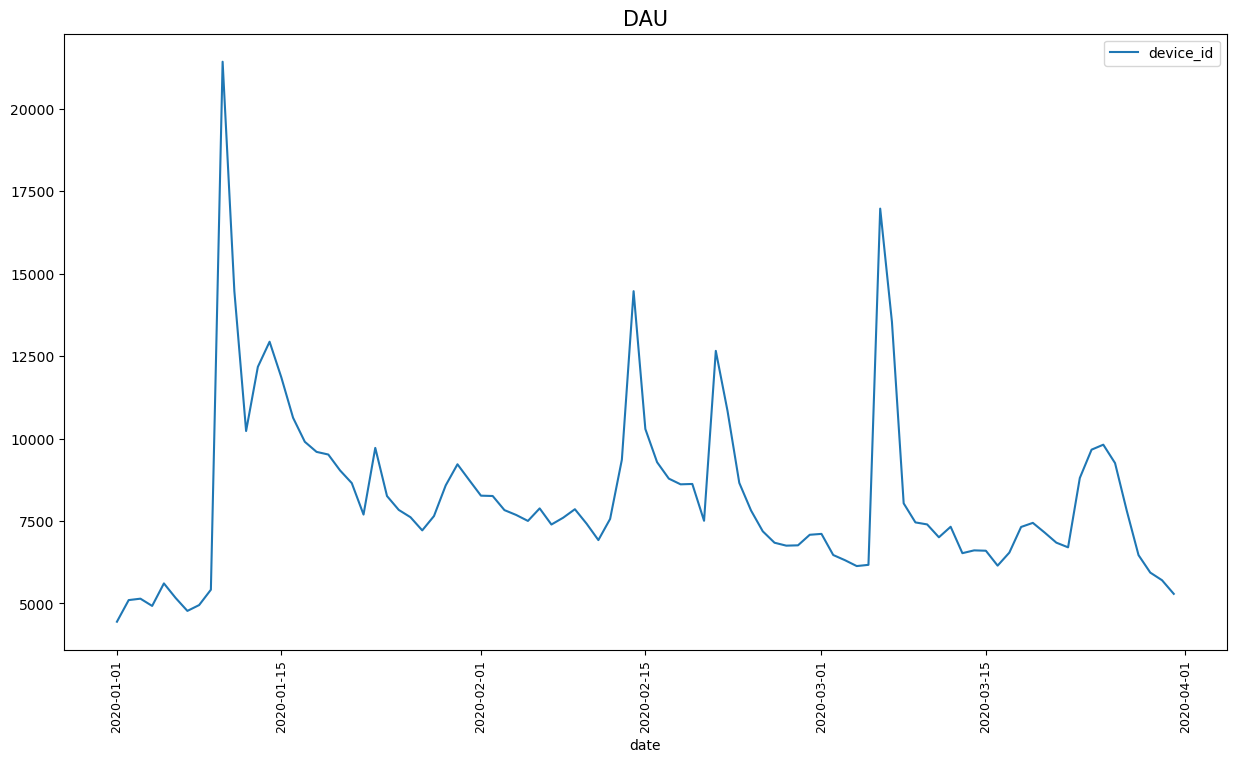

In [568]:
ax, fig = plt.subplots(figsize=(15,8))
fig.set_title('DAU', fontsize=15)
plt.xticks(rotation=90, fontsize = 9)
sns.lineplot(DAU)

In [570]:
WAU = visits.groupby('week_number', as_index = False).agg({'device_id':'nunique'})

In [572]:
WAU['week_number'] = WAU['week_number'].astype('int64')

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'WAU'}, xlabel='week_number', ylabel='device_id'>

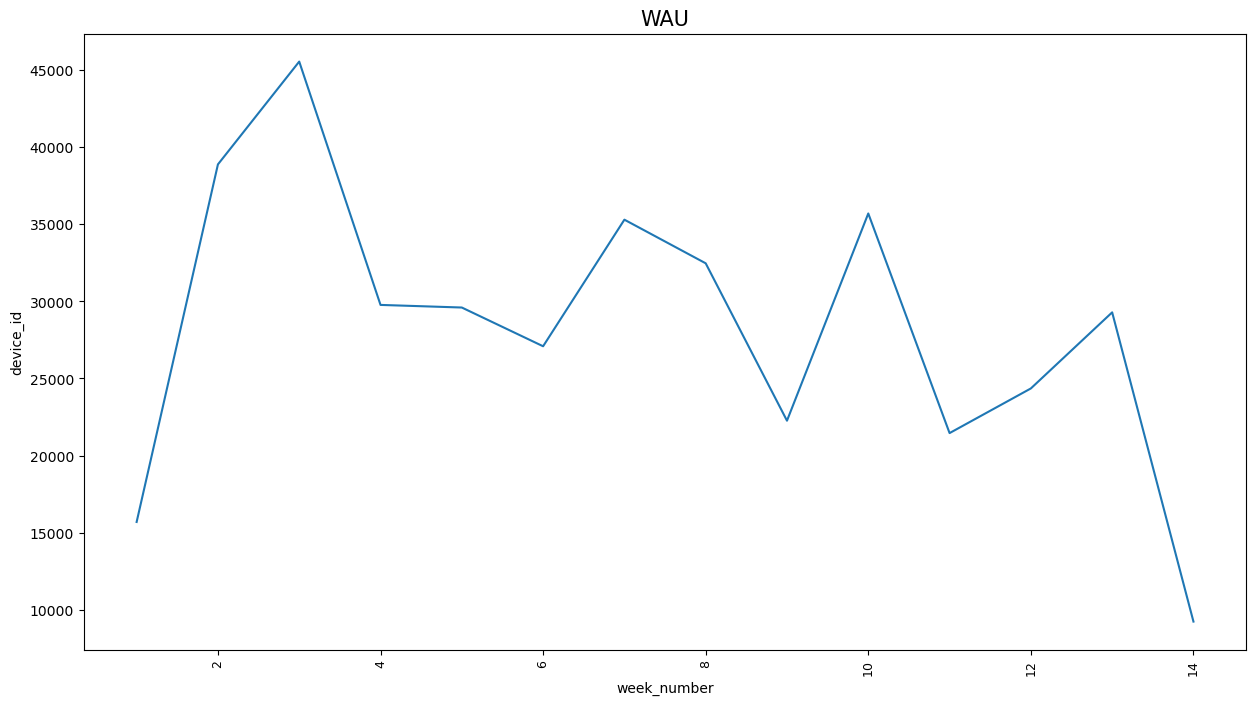

In [574]:
ax, fig = plt.subplots(figsize=(15,8))
fig.set_title('WAU', fontsize=15)
plt.xticks(rotation=90, fontsize = 9)
sns.lineplot(data = WAU, x = 'week_number', y = 'device_id')

In [576]:
MAU = visits.groupby('month').agg({'device_id':'nunique'})
MAU

,device_id
month,
1,99161
2,75032
3,74623


### Конверсии по воронке для зарегистрированных пользователей

Зарегистрированными пользователями считаются те, у которых дата регистрации < дата совершения события

In [603]:
reg_df = df.query('event == "register"')[['date','device_id']] \
   .drop_duplicates(subset='device_id') \
   .rename(columns = {'date' : 'reg_date'})
reg_df.head()

,reg_date,device_id
2669658,2020-01-01,294193
2669659,2020-01-01,22917617
2669660,2020-01-01,15248490
2669661,2020-01-01,252062
2669662,2020-01-01,2251583


In [709]:
already_reg = pd.merge(df, reg_df, on = 'device_id')
already_reg = already_reg.query('reg_date < date')

In [697]:
already_reg.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,reg_date
16,2020-01-08,app_start,NaN,android,669460,female,Moscow,-,2020-01-07
17,2020-01-08,choose_item,NaN,android,669460,female,Moscow,-,2020-01-07
18,2020-01-08,search,NaN,android,669460,female,Moscow,-,2020-01-07
19,2020-01-08,tap_basket,NaN,android,669460,female,Moscow,-,2020-01-07
20,2020-01-09,app_start,NaN,android,669460,female,Moscow,-,2020-01-07


In [699]:
already_reg.shape

(1463946, 9)

In [701]:
already_reg.groupby('event').device_id.nunique()

event
app_start      40991
choose_item    37926
purchase       24880
search         40482
tap_basket     34517
Name: device_id, dtype: int64

In [662]:
already_reg.event.unique()

array(['app_start', 'choose_item', 'search', 'tap_basket', 'purchase',
       'app_install'], dtype=object)

In [707]:
# Количество уникальных зарегистрированных пользователей
users_count = already_reg.device_id.nunique()
users_count

41007

Воронка для зарегистрированных пользователей выглядит следующим образом:

1. Открытие приложения (app_start)
2. Переход на страницу поиска товаров (search)
3. Отправить товар в корзину (choose_item) 
4. Переход в корзину (tap_basket)
5. Подтверждение покупки (purchase) 

* Конверсия из открытия приложения в поиск 

In [711]:
start_count = already_reg.query('event == "app_start"').device_id.nunique()
start_count

40991

In [713]:
search_count = already_reg.query('event == "search"').device_id.nunique()
search_count

40482

In [715]:
print(f"Конверсия из открытия приложения в поиск: {round(search_count / start_count * 100,2)}%")

Конверсия из открытия приложения в поиск: 98.76%


* Конверсия из открытия каталога в перемещение товара в корзину

In [717]:
choose_count = already_reg.query('event == "choose_item"').device_id.nunique()
choose_count

37926

In [719]:
print(f"Конверсия из открытия каталога в перемещение товара в корзину: {round(choose_count / search_count * 100,2)}%")
print(f"Конверсия из открытия приложения в перемещение товара в корзину: {round(choose_count / start_count * 100,2)}%")

Конверсия из открытия каталога в перемещение товара в корзину: 93.69%
Конверсия из открытия приложения в перемещение товара в корзину: 92.52%


* Конверсия перехода в корзину

In [723]:
basket_count = already_reg.query('event == "tap_basket"').device_id.nunique()
basket_count

34517

In [725]:
print(f"Конверсия из перемещения товара в корзину в переход в корзину: {round(basket_count / choose_count * 100,2)}%")
print(f"Конверсия из открытия приложения в переход в корзину: {round(basket_count / start_count * 100,2)}%")

Конверсия из перемещения товара в корзину в переход в корзину: 91.01%
Конверсия из открытия приложения в переход в корзину: 84.21%


* Конверсия подтверждения покупки

In [727]:
purchase_count = already_reg.query('event == "purchase"').device_id.nunique()
purchase_count 

24880

In [729]:
print(f"Конверсия из перехода в корзину в покупку: {round(purchase_count / basket_count * 100,2)}%")
print(f"Конверсия из открытия приложения в покупку: {round(purchase_count  / start_count * 100,2)}%")

Конверсия из перехода в корзину в покупку: 72.08%
Конверсия из открытия приложения в покупку: 60.7%


### Конверсия из установки в покупку за 7 дней

Для разбивки по когортам будем использовать дату регистрации.

In [412]:
install_df = installs[['date','device_id']].rename(columns={'date':'install_date'})
install_df.head()

,install_date,device_id
2515061,2020-01-01,4921563
2515065,2020-01-01,8798567
2515066,2020-01-01,8423608
2515067,2020-01-01,532710
2515068,2020-01-01,16060092


In [424]:
purchases_df = df.query('event == "purchase"')[['date','device_id']].rename(columns={'date':'purchase_date'})
purchases_df.drop_duplicates(inplace = True, subset = 'device_id')
purchases_df

,purchase_date,device_id
7691,2020-01-01,6081155
7692,2020-01-01,77448
7693,2020-01-01,7458607
7694,2020-01-01,3520947
7695,2020-01-01,1170605
...,...,...
2507462,2020-03-31,17964402
2507463,2020-03-31,8700073
2507467,2020-03-31,13278240
2507469,2020-03-31,11864116


Получим информацию о каждом пользователе: дата регистрации, дата первой покупки

In [426]:
cohorts_df = pd.merge(install_df, purchases_df, on = 'device_id', how = 'left')

In [434]:
cohorts_df.head()

,install_date,device_id,purchase_date
0,2020-01-01,4921563,2020-01-10
1,2020-01-01,8798567,NaT
2,2020-01-01,8423608,2020-01-06
3,2020-01-01,532710,2020-01-03
4,2020-01-01,16060092,NaT


Если пользователь не совершал покупок (NaT в поле purchase_date) можем заполнить пропуски датой, превышающей 7 дней с момента регистрации, чтобы считать этих пользователей не сконвертированными.

In [440]:
cohorts_df.purchase_date = cohorts_df.purchase_date.fillna('2024-10-10')

In [444]:
cohorts_df['days_diff'] = (cohorts_df.purchase_date - cohorts_df.install_date).dt.days

In [446]:
cohorts_df['diff_less_7_days'] = cohorts_df.days_diff <= 7 

In [454]:
cohorts_df['diff_less_7_days'] = cohorts_df.diff_less_7_days.astype('int')

In [466]:
purchase_cr = cohorts_df.groupby('install_date').agg({'device_id' : 'count', 'diff_less_7_days' : 'sum'}) \
                        .rename(columns={'device_id' : 'user_count'})
purchase_cr['cr'] = round(purchase_cr.diff_less_7_days / purchase_cr.user_count * 100,2)
purchase_cr

,user_count,diff_less_7_days,cr
install_date,,,
2020-01-01,2818,1094,38.82
2020-01-02,2470,924,37.41
2020-01-03,1888,641,33.95
2020-01-04,1444,491,34.00
2020-01-05,1336,464,34.73
...,...,...,...
2020-03-27,927,207,22.33
2020-03-28,859,171,19.91
2020-03-29,878,168,19.13


In [468]:
purchase_cr.sort_values('cr', ascending = False)

,user_count,diff_less_7_days,cr
install_date,,,
2020-01-09,1124,443,39.41
2020-01-01,2818,1094,38.82
2020-01-13,3582,1358,37.91
2020-01-14,4054,1536,37.89
2020-01-15,3390,1274,37.58
...,...,...,...
2020-03-22,1007,202,20.06
2020-03-28,859,171,19.91
2020-03-18,921,182,19.76
